# Combining the 2022 Election Forecasts

Combining 538 [forecasts](https://projects.fivethirtyeight.com/2022-election-forecast/senate/) for US House, US Senate, and Governor seats and Louis Jacobson's state legislative [ratings](https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/) into an index to find good places to focus in 2022. 

In [1]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

# https://medium.com/@dustinmichels/three-handy-jupyter-notebook-snippets-dcb2f8ddc7db
import sys; sys.path.insert(0, '..')
from election_meta import models as m, scrape as s

In [2]:
# https://stackoverflow.com/questions/65996797
from importlib import reload
reload(s)
# reload(m)

<module 'election_meta.scrape' from '../election_meta/scrape.py'>

# Power Sharing Model

In [3]:
state_pop = pd.read_csv('data/states/population.csv')
state_metadata = state_pop[['state', 'population']].copy()
state_converter = pd.read_csv('data/states/state_converter.csv')
state_metadata = state_metadata.merge(state_converter, on='state')
state_freq = pd.read_csv('data/states/election_frequencies.csv')

power = m.calculate_year_adjusted_seatpower(state_metadata, state_freq)
print(power.keys())
power['statehouse_power'].sort_values(
    by='potential_power', ascending=False
).head(10)

dict_keys(['statehouse_power', 'statesenate_power', 'governor_power', 'presidential_power', 'ussenate_power', 'ushouse_power'])


,state,population,state_abbr,fips,population_multiplier,election_frequency,branch,potential_power
4,California,39237836,CA,6,0.118224,2.0,statehouse,2.955602
41,Texas,29527941,TX,48,0.088968,2.0,statehouse,2.224201
8,Florida,21781128,FL,12,0.065627,2.0,statehouse,1.640670
30,New York,19835913,NY,36,0.059766,2.0,statehouse,1.494146
36,Pennsylvania,12964056,PA,42,0.039061,2.0,statehouse,0.976522
12,Illinois,12671469,IL,17,0.038179,2.0,statehouse,0.954482
19,Maryland,6165129,MD,24,0.018576,4.0,statehouse,0.928781
33,Ohio,11780017,OH,39,0.035493,2.0,statehouse,0.887333
9,Georgia,10799566,GA,13,0.032539,2.0,statehouse,0.813481
31,North Carolina,10551162,NC,37,0.031791,2.0,statehouse,0.794770


# US House

In [4]:
def process_538_legislature(dist, close_range, top, power_val):
    # Each party seatprob sums to 1, so just use one of them, assuming
    # no third parties.
    # hs_dist = hs_dist.eval('seatprob = seatprob_Dparty + seatprob_Rparty')

    # 5% margin around center
    low, high = close_range
    dist = dist.query('@low <= seatsheld <= @high')
    pr_close = dist['seatprob_Dparty'].sum()

    # Interesting, even though this isn't considered a tossup, 63.8% of probability distribution 
    # is in a close outcome. For tossup state legislatures, it's only 0.38. Hm.
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin', 'tipping'
    ]]
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()

    top['potential_power'] = power_val
    top['pr_close'] = pr_close
    top = top.eval('realized_power = potential_power*pr_close*tipping')
    # mean_netpartymargin is dem_twoparty_margin
    top = top.sort_values(by='realized_power', ascending=False)
    return top
    

In [5]:
five_data = s.get_538(
    save_loc='./data/fivethirtyeight/',
    archive_loc='./data/archive/'
)
# Only use _deluxe models:
for key, df in five_data.items(): 
    five_data[key] = df.query('expression == "_deluxe"')

Accessed: house_dist
Accessed: house_toplines
Accessed: senate_dist
Accessed: senate_toplines
Accessed: governor_toplines


In [6]:
hs_top = process_538_legislature(
    dist = five_data['house_dist'],
    close_range = [(435/2) - 0.025*435, (435/2) + 0.025*435],
    top = five_data['house_toplines'],
    power_val = power['ushouse_power']
)
hs_top['branch'] = 'ushouse'
hs_top.head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
64079,ushouse,OH-1,2022-11-02,-5.419296,2.234592,-13.094340,0.027162,OH,25.0,0.43325,0.294204
64142,ushouse,NC-13,2022-11-02,-4.596855,3.204163,-12.295380,0.026725,NC,25.0,0.43325,0.289465
64117,ushouse,NJ-7,2022-11-02,-3.997398,4.450840,-12.485850,0.025837,NJ,25.0,0.43325,0.279852
64246,ushouse,IA-3,2022-11-02,-1.429260,6.004799,-8.813015,0.025725,IA,25.0,0.43325,0.278634
64077,ushouse,OH-13,2022-11-02,-6.085495,1.517921,-13.731410,0.025525,OH,25.0,0.43325,0.276468
64093,ushouse,NY-22,2022-11-02,-4.526840,3.592964,-12.616070,0.025513,NY,25.0,0.43325,0.276332
64339,ushouse,CA-27,2022-11-02,-2.498528,5.830189,-10.764970,0.025500,CA,25.0,0.43325,0.276197
64113,ushouse,NM-2,2022-11-02,-5.144363,3.310024,-13.665280,0.025300,NM,25.0,0.43325,0.274031
64181,ushouse,MI-10,2022-11-02,-5.270866,3.079929,-13.474910,0.024500,MI,25.0,0.43325,0.265366
64366,ushouse,AZ-2,2022-11-02,-3.016685,5.727242,-11.767750,0.024150,AZ,25.0,0.43325,0.261575


In [7]:
hs_top['realized_power'].sum()

10.83125

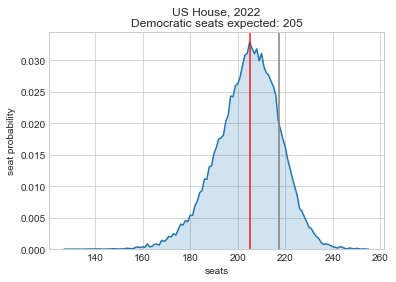

In [8]:
# hs_exp_seats = len(hs_top.query('mean_netpartymargin > 0'))
# Just find most probable seat count:
hs_exp_seats = five_data['house_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

hs_title = f'US House, 2022\nDemocratic seats expected: {hs_exp_seats}'
m.plot_seatprob(
    x = five_data['house_dist']['seatsheld'],
    y = five_data['house_dist']['seatprob_Dparty'],
    mean_outcome = hs_exp_seats,
    midpoint=217.5,
    title=hs_title,
    x_label='seats',
    y_label='seat probability',
    out='data/output/househist.png'
)

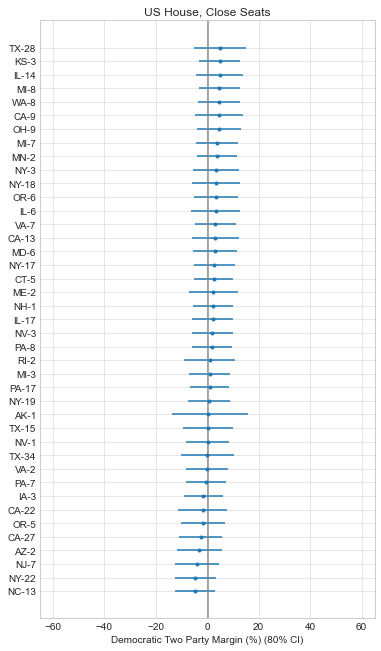

In [9]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
hsplot = hs_top.copy()
hsplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
hsplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
hsplot = hsplot.sort_values(by='mean_netpartymargin', ascending=True)
hsplot.reset_index(drop=True, inplace=True)
#hsplot = hsplot.loc[192:243]
hsplot = hsplot.query('-5 <= mean_netpartymargin <= 5')
m.seatplot(
    hsplot,
    x='mean_netpartymargin',
    y='district',
    title='US House, Close Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/houseseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# US Senate

In [10]:
sen_top = process_538_legislature(
    dist = five_data['senate_dist'],
    close_range = [50 - 2.5, 50 + 2.5],
    top = five_data['senate_toplines'],
    power_val = power['ussenate_power']
)
sen_top['branch'] = 'ussenate'
sen_top.head()

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
5171,ussenate,GA-S3,2022-11-02,-0.134510,6.817404,-7.115835,0.147325,GA,25.0,0.666275,2.453974
5157,ussenate,NV-S3,2022-11-02,-1.246490,6.521194,-8.993834,0.136362,NV,25.0,0.666275,2.271373
5151,ussenate,PA-S3,2022-11-02,0.609097,7.825748,-6.565044,0.134875,PA,25.0,0.666275,2.246596
5176,ussenate,AZ-S3,2022-11-02,2.246258,9.497467,-5.116835,0.104475,AZ,25.0,0.666275,1.740227
5145,ussenate,WI-S3,2022-11-02,-4.546486,2.785625,-11.828030,0.096675,WI,25.0,0.666275,1.610303


In [11]:
sen_top['realized_power'].sum()

16.656875

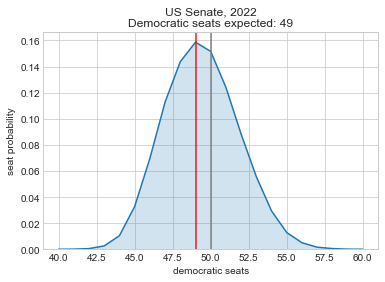

In [12]:
#sen_exp_seats = 36 + len(sen_top.query('mean_netpartymargin > 0')) # 36 seats not up
# Just find most probable seat count:
sen_exp_seats = five_data['senate_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

sen_title = f'US Senate, 2022\nDemocratic seats expected: {sen_exp_seats}'
m.plot_seatprob(
    x = five_data['senate_dist']['seatsheld'],
    y = five_data['senate_dist']['seatprob_Dparty'],
    mean_outcome = sen_exp_seats,
    midpoint=50,
    title=sen_title,
    x_label='democratic seats',
    y_label='seat probability',
    out='data/output/senatehist.png'
)

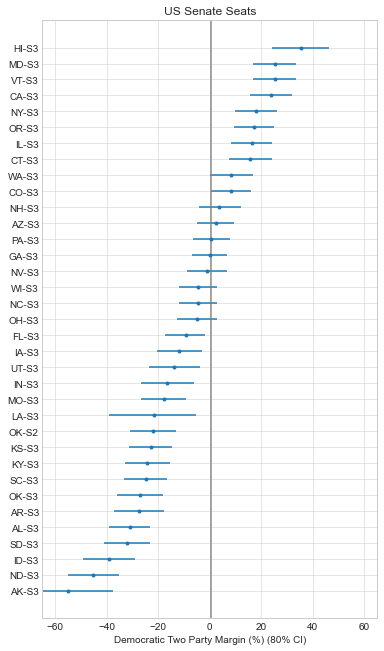

In [13]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
senplot = sen_top.copy()
senplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
senplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
senplot = senplot.sort_values(by='mean_netpartymargin', ascending=True)
senplot.reset_index(drop=True, inplace=True)
m.seatplot(
    senplot,
    x='mean_netpartymargin',
    y='district',
    title='US Senate Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/senateseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# Governors

In [14]:
# https://www.sciencedirect.com/topics/engineering/confidence-interval
# https://mathworld.wolfram.com/StandardDeviation.html
# Assuming normal, 80% CI = mean +- 1.282*SD
# So for WY governor:
# se = (53-38)/1.282
# se

In [15]:
# Instead of simulating, just integrate estimated normal distributions
def estimate_prclose(row):
    dist = stats.norm(
        loc=row['mean_netpartymargin'],
        scale=row['stdev']
    )
    # Integrate around central outcome, in this case 0 is tie
    pr_close = dist.cdf(2.5) - dist.cdf(-2.5)
    return pr_close

def process_538_governors(top, power):
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin'
    ]]
    # 'tipping', what is tipping in the context of Governors? Tip what?
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()
    
    # https://mathworld.wolfram.com/StandardDeviation.html
    # 80% CI is roughly 1.28 sigma
    top.eval('stdev = (p90_netpartymargin - mean_netpartymargin)/1.28155', inplace=True)
    top['pr_close'] = top.apply(estimate_prclose, axis=1)
    
    gov_pow = power[['state_abbr', 'potential_power']].copy()
    top = top.merge(gov_pow, on='state_abbr')
    top['pr_tip'] = 1
    top.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
    
    return top

In [16]:
gov_top = process_538_governors(five_data['governor_toplines'], power['governor_power'])
gov_top.sort_values(by='realized_power', ascending=False).head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,state_abbr,stdev,pr_close,potential_power,pr_tip,realized_power
12,governor,AZ-G1,2022-11-02,-1.790947,4.896137,-8.536034,AZ,5.217966,0.348603,2.192363,1,0.764265
16,governor,WI-G1,2022-11-02,-0.188290,7.772932,-8.077398,WI,6.212182,0.312500,1.776444,1,0.555139
19,governor,MI-G1,2022-11-02,6.839222,14.425820,-0.774721,MI,5.919861,0.174453,3.028322,1,0.528301
18,governor,GA-G1,2022-11-02,-7.068630,-0.160162,-14.092050,GA,5.390713,0.160411,3.253923,1,0.521965
20,governor,OR-G1,2022-11-02,-0.266968,7.595081,-8.148268,OR,6.134797,0.316084,1.279372,1,0.404389
22,governor,TX-G1,2022-11-02,-12.432160,-4.971334,-19.853570,TX,5.821721,0.038839,8.896806,1,0.345543
31,governor,NY-G1,2022-11-02,11.800700,19.802990,3.903564,NY,6.244228,0.057175,5.976585,1,0.341714
27,governor,PA-G1,2022-11-02,9.386654,16.082040,2.695724,PA,5.224444,0.082278,3.906086,1,0.321385
8,governor,FL-G1,2022-11-02,-11.470530,-4.308159,-18.577470,FL,5.588835,0.048023,6.562681,1,0.315163
32,governor,NV-G1,2022-11-02,-0.806835,7.149792,-8.736311,NV,6.208597,0.310315,0.947288,1,0.293958


In [17]:
gov_top['realized_power'].sum()

5.346790854771713

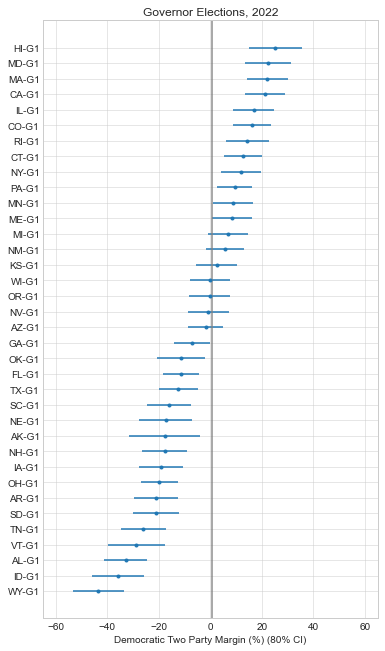

In [18]:
govplot = gov_top.copy()
govplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
govplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
govplot = govplot.sort_values(by='mean_netpartymargin', ascending=True)
govplot.reset_index(drop=True, inplace=True)
m.seatplot(
    govplot,
    x='mean_netpartymargin',
    y='district',
    title='Governor Elections, 2022',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/govseats.png'
)

# State Legislatures

In [19]:
j_categories = pd.read_csv('./data/output/jacobson_category_summary.csv')
j_categories.rename(
    columns={'jacobsonforecast': 'forecast', 'mean': 'dem_seatshare'},
    inplace=True
)
j_categories

,jacobsonforecastnumeric,forecast,dem_seatshare,std,pr_close,CI80_lower,CI80_upper
0,1.0,Safe R,28.697171,9.083162,0.003717,15.991489,40.322580
1,2.0,Likely R,38.826987,6.436138,0.018692,30.000000,45.900000
2,3.0,Lean R,42.848929,6.444749,0.139535,35.676768,50.633354
3,4.0,Toss-up,50.385232,6.223403,0.378049,41.666667,58.192256
4,5.0,Lean D,55.589494,5.377861,0.213115,49.253731,63.265300
5,6.0,Likely D,58.606672,5.866417,0.053571,51.931926,64.857145
6,7.0,Safe D,72.247156,10.883517,0.004854,60.000000,87.500000


In [20]:
state_forecasts = s.get_jacobson(
    save_loc='./data/jacobson/',
    archive_loc='./data/archive/'
)
# Inner join removes states without elections
state_forecasts = state_forecasts.merge(j_categories, on='forecast')
state_forecasts = state_forecasts.merge(state_converter[['state','state_abbr']], on='state')
state_forecasts

Accessed:  https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/


,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr
0,Alabama,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
1,Alabama,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
2,Arkansas,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
3,Arkansas,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
4,Florida,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,FL
...,...,...,...,...,...,...,...,...,...,...
77,Maine,senate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME
78,Michigan,house,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI
79,Michigan,senate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI
80,Arizona,senate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,AZ


In [21]:
st_sen = state_forecasts.query('office == "senate"')
st_sen = st_sen.merge(
    power['statesenate_power'][['state', 'potential_power']],
    on='state'
)
st_sen['pr_tip'] = 1
st_sen.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_sen['office'] = 'statesenate'
st_sen.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
38,Michigan,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI,0.757080,1,0.286213
39,Arizona,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,AZ,0.548091,1,0.207205
40,Nevada,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,NV,0.236822,1,0.089530
25,New York,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,NY,1.494146,1,0.080044
31,Oregon,statesenate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,OR,0.319843,1,0.068163
19,Minnesota,statesenate,Lean R,3.0,42.848929,6.444749,0.139535,35.676768,50.633354,MN,0.429911,1,0.059988
30,Illinois,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
37,Maine,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
2,Florida,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,FL,1.640670,1,0.030667
36,Pennsylvania,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,PA,0.976522,1,0.018253


In [22]:
st_sen['realized_power'].sum()

1.0358948233924525

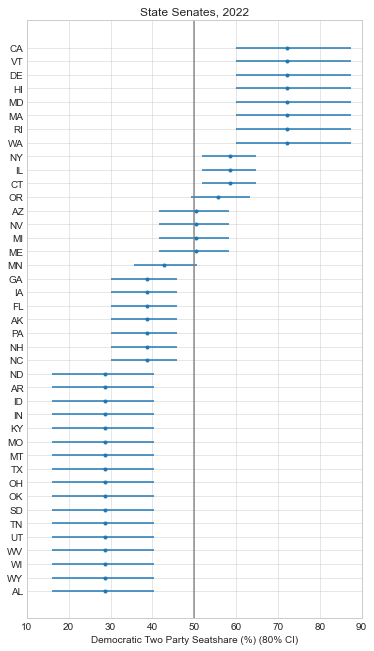

In [23]:
stsen_plot = st_sen.copy()
stsen_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
stsen_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
stsen_plot = stsen_plot.sort_values(by='dem_seatshare', ascending=True)
stsen_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    stsen_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Senates, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90), 
    midpoint=50,
    out='data/output/statesenateseats.png'
)

In [24]:
st_hs = state_forecasts.query('office == "house"')
st_hs = st_hs.merge(
    power['statehouse_power'][['state', 'potential_power']],
    on='state'
)
st_hs['pr_tip'] = 1
st_hs.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_hs['office'] = 'statehouse'
st_hs.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
40,Michigan,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI,0.757080,1,0.286213
21,Minnesota,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MN,0.429911,1,0.162527
33,Illinois,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
39,Maine,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
31,Colorado,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CO,0.437796,1,0.023453
35,Oregon,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,OR,0.319843,1,0.017134
36,Georgia,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,GA,0.813481,1,0.015205
38,North Carolina,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,NC,0.794770,1,0.014856
32,Connecticut,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CT,0.271593,1,0.014550
22,California,statehouse,Safe D,7.0,72.247156,10.883517,0.004854,60.000000,87.500000,CA,2.955602,1,0.014348


In [25]:
st_hs['realized_power'].sum()

0.7140399739536598

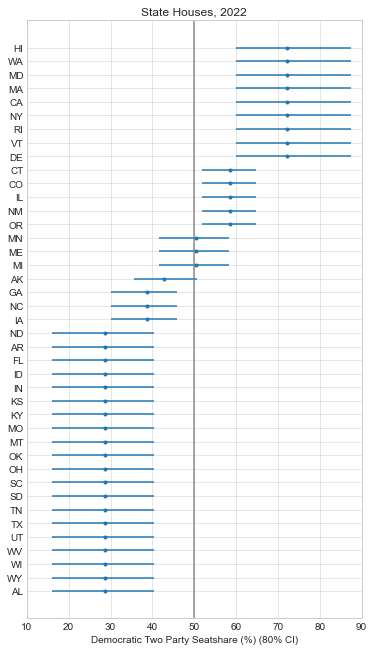

In [26]:
sths_plot = st_hs.copy()
sths_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
sths_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
sths_plot = sths_plot.sort_values(by='dem_seatshare', ascending=True)
sths_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    sths_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Houses, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90),
    midpoint=50,
    out='data/output/statehouseseats.png'
)

# Funding Analysis

In [27]:
state_funding = s.get_followthemoney(
    save_loc='./data/funding/',
    archive_loc='./data/archive/'
)
#state_funding = pd.read_csv('./data/funding/state_funds.csv')
def match_branch(el):
    matches = {
        'Gubernatorial': 'governor',
        'State House/Assembly': 'statehouse',
        'State Senate': 'statesenate'
    }
    return matches[el]

def label_district(row):
    if row['branch'] == 'governor':
        row['district'] = row['district'] + '-G1'
    return row

office_list = ['Gubernatorial', 'State House/Assembly', 'State Senate']
state_funding = state_funding.query('General_Office.isin(@office_list)')
state_funding['branch'] = state_funding['General_Office'].apply(match_branch)
state_funding.rename(
    columns={'Election_Jurisdiction':'district', 'Total_$':'funding'},
    inplace=True
)
state_funding = state_funding[['branch', 'district', 'funding']]
state_funding = state_funding.apply(label_district, axis=1)
state_funding = state_funding.sort_values(by='branch')
state_funding.head(5)

,branch,district,funding
0,governor,TX-G1,2.612609e+08
26,governor,CT-G1,2.450902e+07
27,governor,NM-G1,2.391644e+07
28,governor,AL-G1,2.372752e+07
35,governor,CO-G1,1.674672e+07


In [28]:
fed_funding = s.get_fec(
    save_loc='./data/funding/',
    archive_loc='./data/archive/'
)
fed_candidates = pd.read_csv(
    './data/funding/federal_candidates.csv',
    sep='|',
    dtype='object'
)
sel_cols = ['CAND_ID', 'CAND_ELECTION_YR', 'CAND_OFFICE']
fed_candidates = fed_candidates[sel_cols]
fed_2022 = fed_funding.merge(fed_candidates, on='CAND_ID')
fed_2022 = fed_2022.query('CAND_ELECTION_YR == "2022"')
data_cols = ['TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TRANS_TO_AUTH']
fed_2022[data_cols] = fed_2022[data_cols].apply(pd.to_numeric, axis=1)
# Subtract off double counted activity
# https://www.fec.gov/campaign-finance-data/all-candidates-file-description/
fed_2022.eval(
    'NET_RECEIPTS = TTL_RECEIPTS - TRANS_FROM_AUTH - TRANS_TO_AUTH',
    inplace=True
)
fed_2022.head(5)

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,CAND_ELECTION_YR,CAND_OFFICE,NET_RECEIPTS
0,H2AK00200,"CONSTANT, CHRISTOPHER",C,1,DEM,164637.90,0.00,164037.51,0.0,0,...,NaN,NaN,1000,5000,09/30/2022,8300,0,2022,H,164637.90
1,H2AK01158,"PELTOLA, MARY",I,1,DEM,5785806.88,144363.90,3364338.19,0.0,0,...,NaN,NaN,263041.36,5000,10/19/2022,87401.32,2500,2022,H,5641442.98
2,H2AK01240,"WOOL, ADAM L",O,1,DEM,16217.07,0.00,16217.07,0.0,0,...,NaN,NaN,0,0,07/15/2022,0,0,2022,H,16217.07
3,H2AK00218,"REVAK, JOSHUA CARL",O,2,REP,121841.00,0.00,121841,0.0,0,...,NaN,NaN,5000,0,09/16/2022,14600,0,2022,H,121841.00
4,H2AK00226,"PALIN, SARAH",O,2,REP,1742020.01,112737.77,1621819.49,0.0,0,...,NaN,NaN,76405,0,10/19/2022,590,0,2022,H,1629282.24


In [29]:
senate_funding = fed_2022.query('CAND_OFFICE == "S"')
# For now, just calculate total funding. Maybe a better measure of effort.
# Includes primary challengers.
# # Take top fund getter by party and state
# senate_funding = senate_funding.sort_values(by='NET_RECEIPTS', ascending=False)
# senate_funding = senate_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_PTY_AFFILIATION']
# ).head(1)
# # Then take the top two fund getters by election.
# # Results in 68 records, 2 for every race.
# senate_funding = senate_funding.groupby(
#     by=['CAND_OFFICE_ST']
# ).head(2)
senate_funding = senate_funding.groupby(
    by=['CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']
).agg({'NET_RECEIPTS': 'sum'})
senate_funding.reset_index(drop=False, inplace=True)
senate_funding['branch'] = 'ussenate'
senate_funding['district'] = senate_funding['CAND_OFFICE_ST'] + '-S3'
senate_funding.rename(columns={'NET_RECEIPTS': 'funding'}, inplace=True)
senate_funding = senate_funding[['branch', 'district', 'funding']]
senate_funding.head(5)

,branch,district,funding
0,ussenate,AK-S3,1.321326e+07
1,ussenate,AL-S3,3.072502e+07
2,ussenate,AR-S3,7.928026e+06
3,ussenate,AZ-S3,1.161774e+08
4,ussenate,CA-S3,2.201145e+07


In [30]:
house_funding = fed_2022.query('CAND_OFFICE == "H"')
# For now, include all funding, including primary challengers. This matches
# the state level data, maybe is a better measure of "total effort" put into races.
# # Take top fund getter by party, state, district
# house_funding = house_funding.sort_values(by='NET_RECEIPTS', ascending=False)
# house_funding = house_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'CAND_PTY_AFFILIATION']
# ).head(1)
# # Then take the top two fund getters by election.
# # Results in 846 records, some races aren't contested?
# house_funding = house_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT']
# ).head(2)
house_funding = house_funding.groupby(
    by=['CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']
).agg({'NET_RECEIPTS': 'sum'})
house_funding.reset_index(drop=False, inplace=True)
house_funding['branch'] = 'ushouse'
# Needs to be int to match 538
house_funding['CAND_OFFICE_DISTRICT'] = house_funding['CAND_OFFICE_DISTRICT'].astype('int')
house_funding['CAND_OFFICE_DISTRICT'] = house_funding['CAND_OFFICE_DISTRICT'].astype('string')
house_funding['district'] = house_funding['CAND_OFFICE_ST'] + '-' + house_funding['CAND_OFFICE_DISTRICT']
house_funding.rename(columns={'NET_RECEIPTS': 'funding'}, inplace=True)
house_funding = house_funding[['branch', 'district', 'funding']]
house_funding.head(5)
# There are a few territories included, so not exactly 435
# Just left join the power values onto it. 

,branch,district,funding
0,ushouse,AK-0,10901331.13
1,ushouse,AL-1,818876.89
2,ushouse,AL-2,1313939.97
3,ushouse,AL-3,1950207.42
4,ushouse,AL-4,1433991.32


In [31]:
all_funding = pd.concat([state_funding, house_funding, senate_funding])
all_funding #.head(5)

,branch,district,funding
0,governor,TX-G1,2.612609e+08
26,governor,CT-G1,2.450902e+07
27,governor,NM-G1,2.391644e+07
28,governor,AL-G1,2.372752e+07
35,governor,CO-G1,1.674672e+07
...,...,...,...
29,ussenate,SD-S3,6.753486e+06
30,ussenate,UT-S3,1.725840e+07
31,ussenate,VT-S3,6.519683e+06
32,ussenate,WA-S3,2.944054e+07


# Cumulative Results

In [32]:
# Relabel and standardise data for combination, output
out_cols = [
    'branch', 'district', 'state_abbr', 'forecast_measure',
    'forecast', 'ci_low', 'ci_high', 'ci_measure', 'potential_power',
    'pr_close', 'pr_tip', 'realized_power'
]

final_dfs = []

for df in [sen_top, hs_top, gov_top]:
    df = df.copy()
    df['forecast_measure'] = 'net_dem_twoparty_margin'
    df['ci_measure'] = '80pct'
    df.rename(
        columns={
            'tipping':'pr_tip',
            'mean_netpartymargin': 'forecast',
            'p10_netpartymargin': 'ci_low',
            'p90_netpartymargin': 'ci_high',
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
for df in [st_sen, st_hs]:
    df = df.copy()
    df['forecast_measure'] = 'dem_twoparty_seatshare'
    df['ci_measure'] = '80pct'
    df['district'] = df['state_abbr']
    del df['forecast']
    df.rename(
        columns={
            'dem_seatshare': 'forecast',
            'CI80_lower': 'ci_low',
            'CI80_upper': 'ci_high',
            'office':'branch'
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
cumulative_df = pd.concat(final_dfs)
cumulative_df = cumulative_df.sort_values(
    by='realized_power',
    ascending=False
).reset_index(drop=True)
cumulative_df = cumulative_df.merge(
    all_funding,
    on=['branch', 'district'],
    how='left'
)
cumulative_df['power_pct'] = cumulative_df['realized_power']*100/cumulative_df['realized_power'].sum()
cumulative_df['funding_pct'] = cumulative_df['funding']*100/cumulative_df['funding'].sum()
cumulative_df.eval('funding_gap = power_pct - funding_pct', inplace=True)
cumulative_df.sort_values(by='funding_gap', ascending=False, inplace=True)
cumulative_df.to_csv('data/output/all_elections.csv', index=False)
cumulative_df.head(50)

,branch,district,state_abbr,forecast_measure,forecast,ci_low,ci_high,ci_measure,potential_power,pr_close,pr_tip,realized_power,funding,power_pct,funding_pct,funding_gap
1,ussenate,NV-S3,NV,net_dem_twoparty_margin,-1.246490,-8.993834,6.521194,80pct,25.000000,0.666275,0.136362,2.271373,6.085407e+07,6.567538,1.065626,5.501912
0,ussenate,GA-S3,GA,net_dem_twoparty_margin,-0.134510,-7.115835,6.817404,80pct,25.000000,0.666275,0.147325,2.453974,1.634606e+08,7.095517,2.862388,4.233130
2,ussenate,PA-S3,PA,net_dem_twoparty_margin,0.609097,-6.565044,7.825748,80pct,25.000000,0.666275,0.134875,2.246596,1.457847e+08,6.495896,2.552861,3.943036
5,ussenate,NC-S3,NC,net_dem_twoparty_margin,-4.583309,-11.838550,2.623390,80pct,25.000000,0.666275,0.093188,1.552213,5.609973e+07,4.488129,0.982372,3.505756
4,ussenate,WI-S3,WI,net_dem_twoparty_margin,-4.546486,-11.828030,2.785625,80pct,25.000000,0.666275,0.096675,1.610303,8.049015e+07,4.656095,1.409477,3.246618
3,ussenate,AZ-S3,AZ,net_dem_twoparty_margin,2.246258,-5.116835,9.497467,80pct,25.000000,0.666275,0.104475,1.740227,1.161774e+08,5.031761,2.034403,2.997358
7,ussenate,NH-S3,NH,net_dem_twoparty_margin,3.693089,-4.376781,11.917020,80pct,25.000000,0.666275,0.074825,1.246351,3.904914e+07,3.603747,0.683796,2.919951
6,ussenate,OH-S3,OH,net_dem_twoparty_margin,-4.947571,-12.823540,2.914108,80pct,25.000000,0.666275,0.085500,1.424163,1.011463e+08,4.117880,1.771191,2.346690
8,governor,AZ-G1,AZ,net_dem_twoparty_margin,-1.790947,-8.536034,4.896137,80pct,2.192363,0.348603,1.000000,0.764265,3.551802e+07,2.209825,0.621962,1.587863
20,ushouse,OH-1,OH,net_dem_twoparty_margin,-5.419296,-13.094340,2.234592,80pct,25.000000,0.433250,0.027162,0.294204,4.289682e+06,0.850673,0.075117,0.775555


In [33]:
# A few missing records
cumulative_df[cumulative_df['funding'].isnull()]

,branch,district,state_abbr,forecast_measure,forecast,ci_low,ci_high,ci_measure,potential_power,pr_close,pr_tip,realized_power,funding,power_pct,funding_pct,funding_gap
64,ushouse,AK-1,AK,net_dem_twoparty_margin,0.48431,-13.535420,15.70516,80pct,25.0,0.433250,0.011862,0.128486,NaN,0.371509,NaN,NaN
155,ussenate,OK-S2,OK,net_dem_twoparty_margin,-22.16291,-31.175530,-13.26105,80pct,25.0,0.666275,0.000763,0.012701,NaN,0.036724,NaN,NaN
227,ushouse,ND-1,ND,net_dem_twoparty_margin,-63.15974,-36.447340,-16.11784,80pct,25.0,0.433250,0.000250,0.002708,NaN,0.007829,NaN,NaN
228,ushouse,DE-1,DE,net_dem_twoparty_margin,14.73576,6.639677,22.83867,80pct,25.0,0.433250,0.000237,0.002572,NaN,0.007438,NaN,NaN
438,ushouse,WY-1,WY,net_dem_twoparty_margin,-50.48880,-59.848220,-41.13956,80pct,25.0,0.433250,0.000000,0.000000,NaN,0.000000,NaN,NaN
532,ushouse,SD-1,SD,net_dem_twoparty_margin,-84.57706,-90.744140,-78.02412,80pct,25.0,0.433250,0.000000,0.000000,NaN,0.000000,NaN,NaN
535,ushouse,VT-1,VT,net_dem_twoparty_margin,26.89602,17.978350,35.93501,80pct,25.0,0.433250,0.000000,0.000000,NaN,0.000000,NaN,NaN


In [34]:
#sns.lmplot(data=cumulative_df, x="power_pct", y="funding_pct", hue='branch')
#sns.scatterplot(data=cumulative_df, x="power_pct", y="funding_pct", hue='branch')

In [35]:
matrix = cumulative_df.groupby(by=['state_abbr', 'branch']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state_abbr', columns='branch', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
matrix.to_csv('data/output/statescore-matrix.csv', index=True)

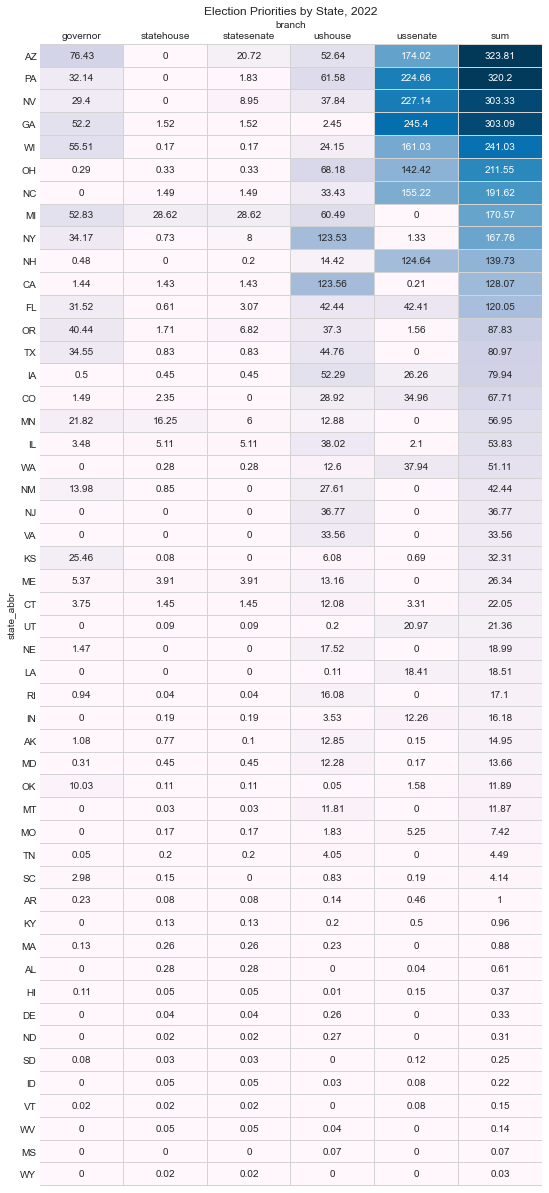

In [36]:
#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[9,21]) #[9, 20] [7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(matrix, decimals=2),
    ax=ax, annot=True, fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=False, cmap='PuBu') 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
plt.title('Election Priorities by State, 2022')
plt.savefig('../heatmap.png', bbox_inches='tight')
heatmap

In [37]:
summary_df = cumulative_df.groupby(
    by='branch'
).agg(
    {'realized_power':'sum', 'funding': 'sum'}
).sort_values(
    by='realized_power',
    ascending=False
)
summary_df.reset_index(drop=False, inplace=True)

# Funding now from aggregation above, from race level data
# State Legislative funding:
# https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
# https://www.opensecrets.org/news/2022/03/a-behind-the-scenes-look-at-collecting-state-campaign-finance-data-in-2022/
# By state and office: https://www.followthemoney.org/show-me#[{1|gro=y,c-r-ot,s
# https://www.followthemoney.org/show-me#[{1|gro=y,c-r-ot,d-ad-st
# Federal data:
# https://www.fec.gov/data/raising-bythenumbers/
# https://www.opensecrets.org/elections-overview
# funding = pd.DataFrame({
#     'branch': ['ussenate', 'ushouse', 'governor', 'statesenate', 'statehouse'],
#     'funding': [1057769329, 1527419371, 1427297635, 343214789, 536928934]
# })
# summary_df = summary_df.merge(funding, on='branch')

summary_df.eval('power_pct = 100*realized_power/realized_power.sum()', inplace=True)
summary_df.eval('funding_pct = 100*funding/funding.sum()', inplace=True)
#del summary_df['funding']
summary_df.eval('funding_gap = power_pct - funding_pct', inplace=True)
print('https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y')
print('https://www.fec.gov/data/raising-bythenumbers/')

summary_df.set_index('branch', inplace=True)

summary_df = summary_df.style.format({
    "realized_power": "{:.1f}",
    "power_pct": "{:.1f}",
    "funding_pct": "{:.1f}",
    "funding_gap": "{:.1f}",
    "funding": "{:20,.2f}"
}).background_gradient(
    #subset=['power_pct', 'funding_pct', 'funding_gap']
)
m.output_table(summary_df, './data/output/power_frac.html')
summary_df

https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
https://www.fec.gov/data/raising-bythenumbers/


,realized_power,funding,power_pct,funding_pct,funding_gap
branch,,,,,
ussenate,16.7,"1,315,281,005.82",48.2,23.0,25.1
ushouse,10.8,"1,835,778,775.76",31.3,32.1,-0.8
governor,5.3,"1,608,891,765.29",15.5,28.2,-12.7
statesenate,1.0,"381,098,000.41",3.0,6.7,-3.7
statehouse,0.7,"569,589,707.02",2.1,10.0,-7.9


In [38]:
datatable_def = '''{
    columnDefs: [
        { 'targets': [5,6,7,8], type:'num'}
    ],
    autoWidth: true,
    paging: false,
    scrollY: 600,
    scrollX: 900,
    order: [[8, 'desc']],
}'''

out_table = cumulative_df.copy()
out_table = out_table[[
    'branch', 'district', 'state_abbr',
    'forecast', 'realized_power', 'power_pct', 'funding_pct',
    'funding_gap'
]]
# Remove missing funding, about 5 districts
out_table = out_table[~out_table['funding_pct'].isnull()]
out_table.reset_index(drop=True, inplace=True)
out_table = out_table.style.background_gradient(
        subset=[
            'realized_power', 'power_pct',
            'funding_pct', 'funding_gap'
        ]
    ).set_precision(2) \
    .set_table_attributes('class="row-border responsive compact stripe hover" style="width:100%"') \
    .render()
m.output_interactive_table(
    table=out_table,
    datatable_def=datatable_def,
    outpath='./data/output/office_table.html'
)

In [41]:
# Output
# !cp -vr data/output/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta-2022